# Explore here

In [15]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import random  # For selecting random images

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

import tensorflow as tf


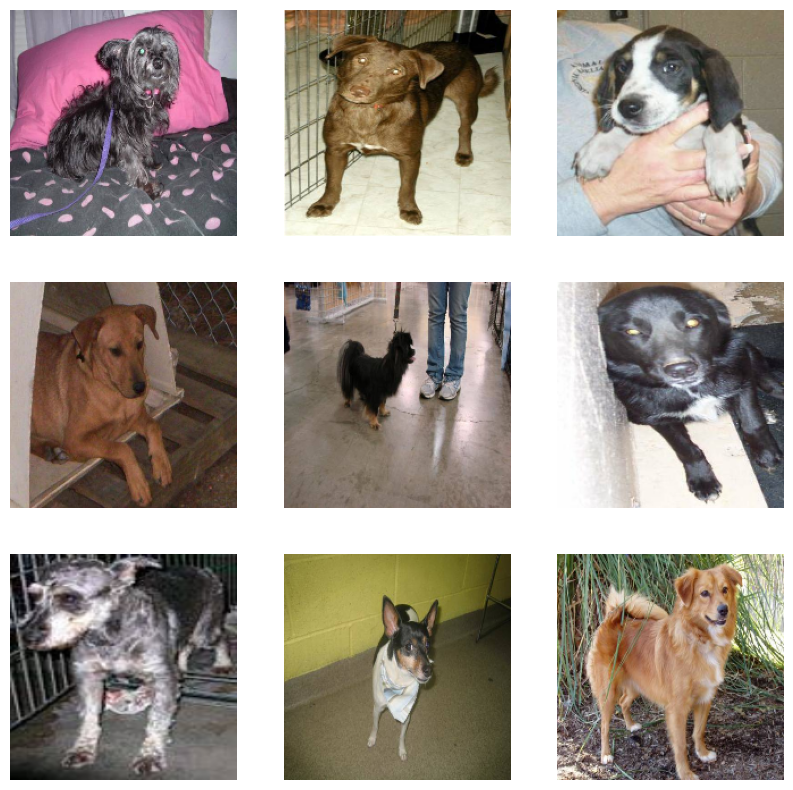

In [ ]:

# load and display first nine dog images.

dog_dir = r"C:\Users\aless\Downloads\train\train\dog"
dog_images = [os.path.join(dog_dir, fname) for fname in os.listdir(dog_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

# Load first nine dog images
dog_pics = []
for img_path in dog_images[:9]:
    img = cv2.imread(img_path)  # Read image
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (200, 200))  # Resize to 200x200
        dog_pics.append(img)
    else:
        print(f"Failed to load image {img_path}")

# Plot the images
plt.figure(figsize=(10,10))
for i in range(len(dog_pics)):
    plt.subplot(3,3,i+1)
    plt.imshow(dog_pics[i])
    plt.axis('off')
plt.show()


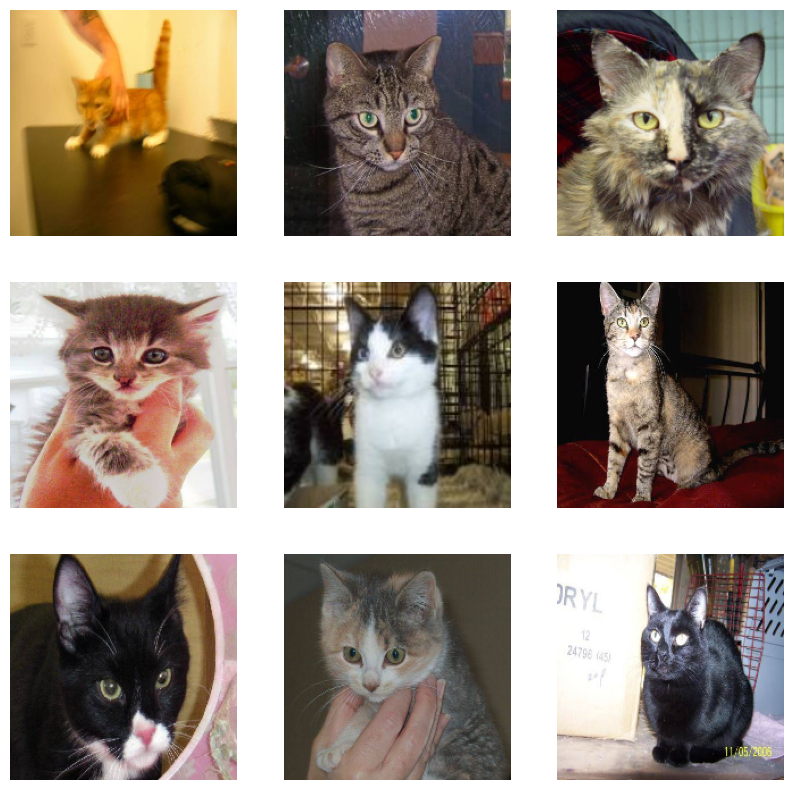

In [ ]:
#  Load and display first nine cat images.

cat_dir = r"C:\Users\aless\Downloads\train\train\cat"
cat_images = [os.path.join(cat_dir, fname) for fname in os.listdir(cat_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

# Load first nine cat images
cat_pics = []
for img_path in cat_images[:9]:
    img = cv2.imread(img_path)  # Read image
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (200, 200))  # Resize to 200x200
        cat_pics.append(img)
    else:
        print(f"Failed to load image {img_path}")

# Plot the images
plt.figure(figsize=(10,10))
for i in range(len(cat_pics)):
    plt.subplot(3,3,i+1)
    plt.imshow(cat_pics[i])
    plt.axis('off')
plt.show()


In [6]:
#  Organize images into subdirectories for flow_from_directory.

train_dir = r"C:\Users\aless\Downloads\train\train"
train_dog_dir = os.path.join(train_dir, 'dog')
train_cat_dir = os.path.join(train_dir, 'cat')

os.makedirs(train_dog_dir, exist_ok=True)
os.makedirs(train_cat_dir, exist_ok=True)

for fname in os.listdir(train_dir):
    source = os.path.join(train_dir, fname)
    if os.path.isfile(source):  # Check if it's a file
        if fname.startswith('dog'):
            shutil.move(source, train_dog_dir)
        elif fname.startswith('cat'):
            shutil.move(source, train_cat_dir)


In [5]:
# Create ImageDataGenerator objects for training and validation data.

# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Rescale and split for validation

# Create train generator
train_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\aless\Downloads\train\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\aless\Downloads\train\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# Build the model.

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=2, activation="softmax"))

c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
x = base_model.output
x = Flatten()(x)  # Flatten output
x = Dense(256, activation='relu')(x)  # Add dense layer
x = Dense(2, activation='softmax')(x)  # Output layer

# Create new model
model = Model(inputs=base_model.input, outputs=x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Set learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#  Update ImageDataGenerator for new input size

# Adjust target size to (150, 150)
target_size = (150, 150)
batch_size = 32

# Update train generator
train_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\aless\Downloads\train\train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Update validation generator
validation_generator = train_datagen.flow_from_directory(
    directory=r"C:\Users\aless\Downloads\train\train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
#  Train the model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5  
)


Epoch 1/5


c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 514ms/step - accuracy: 0.8476 - loss: 0.3358 - val_accuracy: 0.9089 - val_loss: 0.2177
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0916
Epoch 3/5


c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 317s 506ms/step - accuracy: 0.9182 - loss: 0.1933 - val_accuracy: 0.9071 - val_loss: 0.2199
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.1161
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 311s 497ms/step - accuracy: 0.9384 - loss: 0.1555 - val_accuracy: 0.9008 - val_loss: 0.2346


In [ ]:
# Create callback objects and pass them to fit.

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=2, mode='max')

callbacks_list = [checkpoint, earlystop]

# Re-train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    callbacks=callbacks_list
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 312s 500ms/step - accuracy: 0.9496 - loss: 0.1302 - val_accuracy: 0.9145 - val_loss: 0.2180
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.4116
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 318s 508ms/step - accuracy: 0.9589 - loss: 0.1079 - val_accuracy: 0.9127 - val_loss: 0.2194


In [19]:

# Load the best model saved by ModelCheckpoint
best_model_path = 'best_model.keras'  # The filename specified in ModelCheckpoint
best_model = load_model(best_model_path)

# Define the path to save the model
save_dir = r"C:\Users\aless\Desktop\4 geeks projects\ale---Image-Classifier-Project-Tutorial\models"
model_name = "cat_dog_classifier.keras"  # Use .keras extension to match Keras's expected format

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the best model to the specified path
model_path = os.path.join(save_dir, model_name)
best_model.save(model_path)
print(f"Best model saved to {model_path}")


Best model saved to C:\Users\aless\Desktop\4 geeks projects\ale---Image-Classifier-Project-Tutorial\models\cat_dog_classifier.keras


In [23]:
# Load the best model
best_model = load_model('best_model.keras')

# Evaluate on validation data
val_loss, val_acc = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc*100:.2f}%')

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    directory=r"C:\Users\aless\Downloads\test1\test1",
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False,
    classes=['.']  
)

# Print the number of images found
print(f'Found {test_generator.samples} images in the test set.')

# Check if any images are found
if test_generator.samples == 0:
    print("No images found in the test directory.")
else:
    # Make predictions on test data
    predictions = best_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Map class indices to labels
    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[k] for k in predicted_classes]

    # Print first few predictions
    print(predicted_labels[:10])


157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 389ms/step - accuracy: 0.9177 - loss: 0.2213
Validation Accuracy: 91.42%
Found 12500 images belonging to 1 classes.
Found 12500 images in the test set.
391/391 ━━━━━━━━━━━━━━━━━━━━ 158s 403ms/step
['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


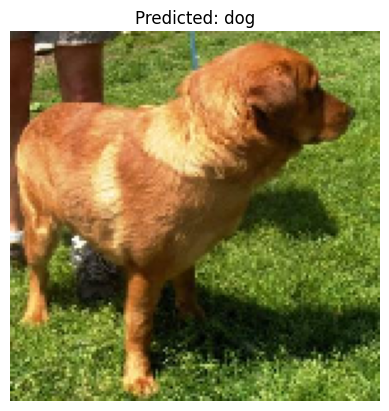

In [38]:
# Step 4.4: Test the model with a random test image

# Set test directory
test_dir = r"C:\Users\aless\Downloads\test1\test1"

# Get list of test images
test_images = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)
               if fname.endswith('.jpg') or fname.endswith('.png')]

# Select a random image
random_image_path = random.choice(test_images)

# Load and preprocess the image
image = load_img(random_image_path, target_size=target_size)  # Load image
image_array = img_to_array(image)  # Convert to array
image_array = image_array / 255.0  # Normalize pixel values
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Make prediction
prediction = best_model.predict(image_array)
predicted_class = np.argmax(prediction, axis=1)[0]
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
predicted_label = inv_class_indices[predicted_class]

# Display the image and prediction
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {predicted_label}')
plt.show()


